In [3]:
!pip install contractions
!pip install textsearch
!pip install tqdm
!pip install tensorflow
import nltk
nltk.download('punkt')


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/27/7e/9699c0ebd2bf124df8446bc4767390c023f7bb2d072b7ff92ae7f3fc1379/tensorflow-2.14.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/29/ab/79512973474b56a7f9efef2cab0ec2f803759e90e1b65ff0383d2b0788c4/tensorflow_intel-2.14.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to C:\Users\utilizador.DESKTOP-
[nltk_data]     DGA4C5V.000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

Information about the data

In [50]:
df = pd.read_pickle("clean_training_data.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42000 entries, 17358 to 21435
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      42000 non-null  object
 1   emotions  42000 non-null  object
dtypes: object(2)
memory usage: 984.4+ KB


Prepare Train Test Split

In [51]:
# build train and test datasets
text = df['text'].values
sentiments = df['emotions'].values

train_text = text[:21000]
train_sentiments = sentiments[:21000]

test_text = text[21000:]
test_sentiments = sentiments[21000:]

In [52]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_text)
t.word_index['<PAD>'] = 0

In [53]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('cured', 19011), ('<PAD>', 0), 1)

In [54]:
train_sequences = t.texts_to_sequences(train_text)

test_sequences = t.texts_to_sequences(test_text)

In [56]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=19012
Number of Documents=21000


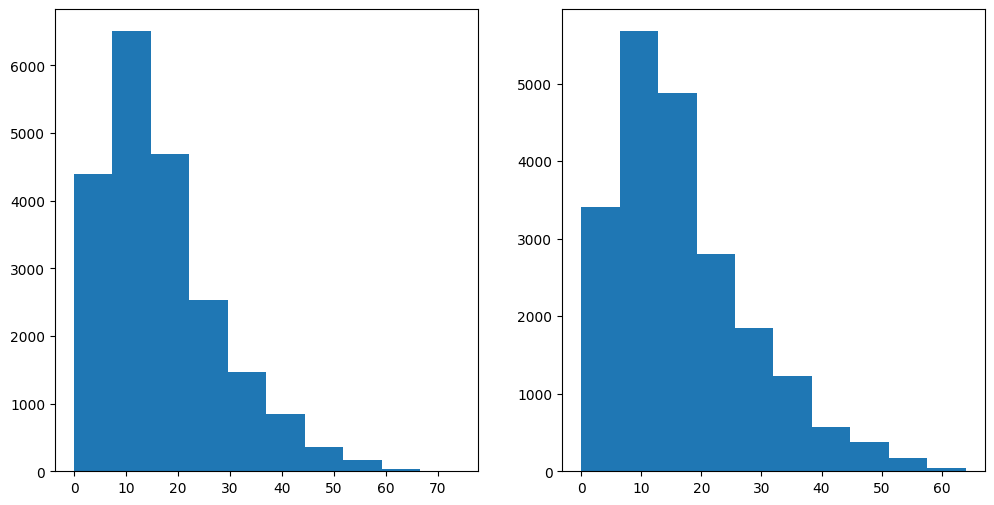

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [141]:
MAX_SEQUENCE_LENGTH = 1000

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape
print(X_train.shape)

(21000, 1000)


In [142]:
from sklearn.preprocessing import LabelBinarizer

# Certifique-se de que suas classes estejam em ordem
classes = ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']

label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

# One-hot encoding for training and testing labels
y_train = label_binarizer.transform(train_sentiments)
y_test = label_binarizer.transform(test_sentiments)

print(y_train.shape)

# Now, y_train and y_test will have a shape of (number_of_samples, 7)
# where 7 is the number of classes (emotions) you have


(21000, 7)


Prepare the Model

Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [143]:
EMBED_SIZE = 300
EPOCHS=3
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # Output layer with softmax activation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 1000, 300)         5703600   
                                                                 
 conv1d_54 (Conv1D)          (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_54 (MaxPooli  (None, 500, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_55 (Conv1D)          (None, 500, 64)           32832     
                                                                 
 max_pooling1d_55 (MaxPooli  (None, 250, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_56 (Conv1D)          (None, 250, 32)         

Model Training

In [144]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/3
148/148 [==============================] - 269s 2s/step - loss: 1.4294 - accuracy: 0.3987 - val_loss: 1.0358 - val_accuracy: 0.5890
Epoch 2/3
148/148 [==============================] - 265s 2s/step - loss: 0.7747 - accuracy: 0.7058 - val_loss: 0.6328 - val_accuracy: 0.8005
Epoch 3/3
148/148 [==============================] - 286s 2s/step - loss: 0.3737 - accuracy: 0.8783 - val_loss: 0.5058 - val_accuracy: 0.8433


In [145]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

657/657 [==============================] - 82s 124ms/step - loss: 0.5444 - accuracy: 0.8289
Accuracy: 82.89%


In [149]:
predicted_probabilities = model.predict(X_test)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_probabilities[:10]

657/657 [==============================] - 81s 123ms/step


array([[1.62013352e-01, 3.17254849e-03, 6.22493885e-02, 2.94714687e-06,
        3.77798220e-03, 7.68783629e-01, 5.60024311e-08],
       [9.94486868e-01, 1.29371358e-04, 9.13976328e-05, 1.31250957e-08,
        1.17434305e-03, 4.11803927e-03, 8.65661320e-09],
       [1.84156090e-01, 3.78353819e-02, 1.01118363e-01, 3.04127607e-05,
        8.18160479e-04, 6.76040292e-01, 1.32889045e-06],
       [1.05998516e-01, 3.04389978e-03, 5.39336950e-02, 2.30536557e-06,
        4.03071288e-03, 8.32990885e-01, 4.23531326e-08],
       [2.99399206e-03, 1.41474193e-05, 2.36091037e-05, 1.01640828e-10,
        9.96721923e-01, 2.46334384e-04, 2.60037877e-11],
       [9.53841329e-01, 8.70082353e-04, 5.28330123e-03, 2.60325237e-06,
        1.12717564e-04, 3.98898832e-02, 1.24847233e-07],
       [1.39700044e-02, 9.03325856e-01, 5.26483618e-02, 5.72134648e-03,
        2.96280952e-04, 2.31001545e-02, 9.38124955e-04],
       [2.04594322e-02, 2.39145957e-04, 1.45987689e-03, 5.64276981e-09,
        9.64165032e-01, 1

In [153]:
predicted_labels[:10]
predicted_emotions = [classes[idx] for idx in predicted_labels]
predicted_emotions[:10]

['sadness',
 'anger',
 'sadness',
 'sadness',
 'neutral',
 'anger',
 'fear',
 'neutral',
 'surprise',
 'love']

In [154]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_sentiments, predicted_emotions))
pd.DataFrame(confusion_matrix(test_sentiments, predicted_emotions), index=classes, columns=classes)

              precision    recall  f1-score   support

       anger       0.81      0.80      0.81      3036
        fear       0.83      0.87      0.85      3046
         joy       0.77      0.72      0.74      2959
        love       0.91      0.92      0.91      3005
     neutral       0.87      0.86      0.86      2968
     sadness       0.73      0.69      0.71      2978
    surprise       0.88      0.94      0.91      3008

    accuracy                           0.83     21000
   macro avg       0.83      0.83      0.83     21000
weighted avg       0.83      0.83      0.83     21000



,anger,fear,joy,love,neutral,sadness,surprise
anger,2428,111,52,6,195,234,10
fear,36,2661,14,4,14,54,263
joy,94,62,2116,259,56,308,64
love,8,59,128,2766,0,1,43
neutral,161,49,26,0,2557,175,0
sadness,260,89,402,20,131,2061,15
surprise,0,190,0,0,0,0,2818
